In [3]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path

In [6]:
IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [7]:
import seaborn as sns

In [8]:
from scipy.stats import pearsonr, spearmanr
from talib import RSI, BBANDS, MACD, ATR

In [9]:
class DataPrep:
    
    def __init__(self,ticker, source='assets.h5', destination='data.h5', data_type='prices' ):
        self.source = source
        self.ticker = ticker
        self.path = 'yfinance/{}/{}'.format(data_type,ticker.lower())
        self.destination = destination
        self.dest_path = 'model_data/{}'.format(ticker)
        
    def extract_data(self):
        with pd.HDFStore('assets.h5') as store:
            data = (store[self.path]
                    .dropna()
                    .drop(['Close'], axis = 1))
        return data
    
    def _compute_bb(self,close):
        high, mid, low = BBANDS(close, timeperiod=20)
        return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)
    
    def _compute_atr(self,price_data):
        df = ATR(price_data.high, price_data.low, 
                 price_data.close, timeperiod=14)
        return df.sub(df.mean()).div(df.std())
    
    def _compute_macd(self,close):
        macd = MACD(close)[0]
        return (macd - np.mean(macd))/np.std(macd)
            
    def transform_data(self, frame=None):
        
            
            frame_tr = frame.rename(columns ={ "Open": "open",
                                                "High": "high",
                                                "Low" : "low",
                                               "Adj Close" : "close",
                                               "Volume" : "volume"})
            
            #RSI
            frame_tr['rsi'] = frame_tr.close.transform(RSI)
            
            #Bollinger bands
            
            frame_tr = frame_tr.join(frame_tr.close.transform(self._compute_bb))
            frame_tr['bb_high'] = frame_tr.bb_high.sub(frame_tr.close).div(frame_tr.bb_high).apply(np.log1p)
            frame_tr['bb_low'] = frame_tr.close.sub(frame_tr.bb_low).div(frame_tr.close).apply(np.log1p)
            
            # average true range
            
            frame_tr['atr'] = self._compute_atr(frame_tr)
            
            #moving average convergence/divergence
            
            frame_tr['macd'] = self._compute_macd(frame_tr.close)
            
            #lagged returns
            
            lags = [1, 5, 10, 21, 42, 63]
            

            for lag in lags:
                frame_tr['return_{}d'.format(lag)] = np.log(frame_tr.close/frame_tr.close.shift(lag))
                
            #shifted lag returns
            
            for t in [1, 2, 3, 4, 5]:
                for lag in [1, 5, 10, 21]:
                    frame_tr[f'return_{lag}d_lag{t}'] = (frame_tr[f'return_{lag}d'].shift(t * lag))
                    
               
            #forward returns
            
            for t in [1, 5, 10, 21]:
                frame_tr[f'target_{t}d'] = frame_tr[f'return_{t}d'].shift(-t)
                
            #add month and year information
            
            frame_tr['year'] = frame_tr.index.year
            frame_tr['month'] = frame_tr.index.month
            
            frame_tr = pd.get_dummies(frame_tr, columns = ['month'], prefix_sep=['_'],
                        drop_first = True)
                
            frame_tr.dropna(inplace = True)
            
            frame_tr.to_hdf(self.destination, self.dest_path )
            
            print("transformed {} can be found in {} under {}".format(self.ticker, self.destination, self.dest_path))
            
            return frame_tr
        
    def extract_transform(self):
        
        e = self.extract_data()
        return self.transform_data(e)
    

In [17]:
ticker = 'msft'

In [18]:
p = DataPrep(ticker)

In [19]:
f = p.extract_transform()
f

transformed msft can be found in data.h5 under model_data/msft


,open,high,low,close,volume,rsi,bb_high,bb_low,atr,macd,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-06,23.700001,24.090000,23.580000,18.349072,73592000,35.947685,0.118015,0.046348,-0.199741,-0.568015,...,0,0,0,0,1,0,0,0,0,0
2010-07-07,23.820000,24.320000,23.610001,18.718826,79965300,41.488529,0.101522,0.066358,-0.211550,-0.540769,...,0,0,0,0,1,0,0,0,0,0
2010-07-08,24.600000,24.620001,23.969999,18.803555,50758100,42.711489,0.097602,0.071396,-0.227079,-0.512637,...,0,0,0,0,1,0,0,0,0,0
2010-07-09,24.330000,24.410000,24.150000,18.695719,53806100,41.521985,0.101643,0.068421,-0.260779,-0.491360,...,0,0,0,0,1,0,0,0,0,0
2010-07-12,24.430000,24.889999,24.420000,19.127100,49854200,47.786481,0.080665,0.088264,-0.253617,-0.455454,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-23,245.110001,248.279999,244.270004,246.961441,19508500,58.966996,0.024868,0.125776,0.473996,0.892855,...,0,0,0,0,0,0,0,0,1,0
2022-11-25,247.309998,248.699997,246.729996,246.871658,9200800,58.866888,0.030826,0.123271,0.152334,1.073376,...,0,0,0,0,0,0,0,0,1,0
2022-11-28,246.080002,246.649994,240.800003,241.155975,24778200,52.729612,0.054181,0.104415,0.121966,0.985453,...,0,0,0,0,0,0,0,0,1,0


## Data Exploration

### RSI

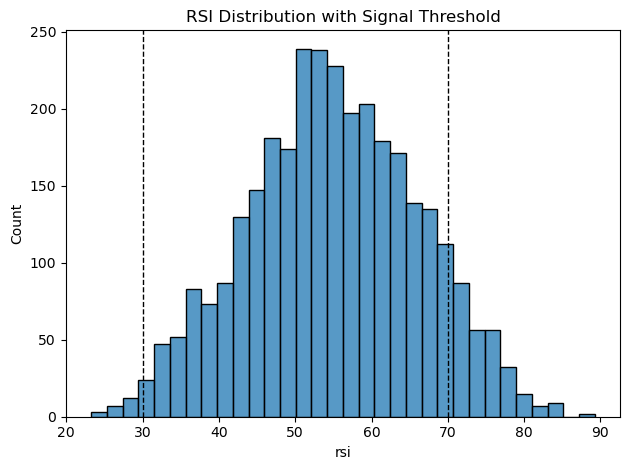

In [20]:
ax = sns.histplot(f.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
plt.tight_layout()
save_fig("RSI_distribution_{}".format(ticker))

### Distribution of bollinger bands

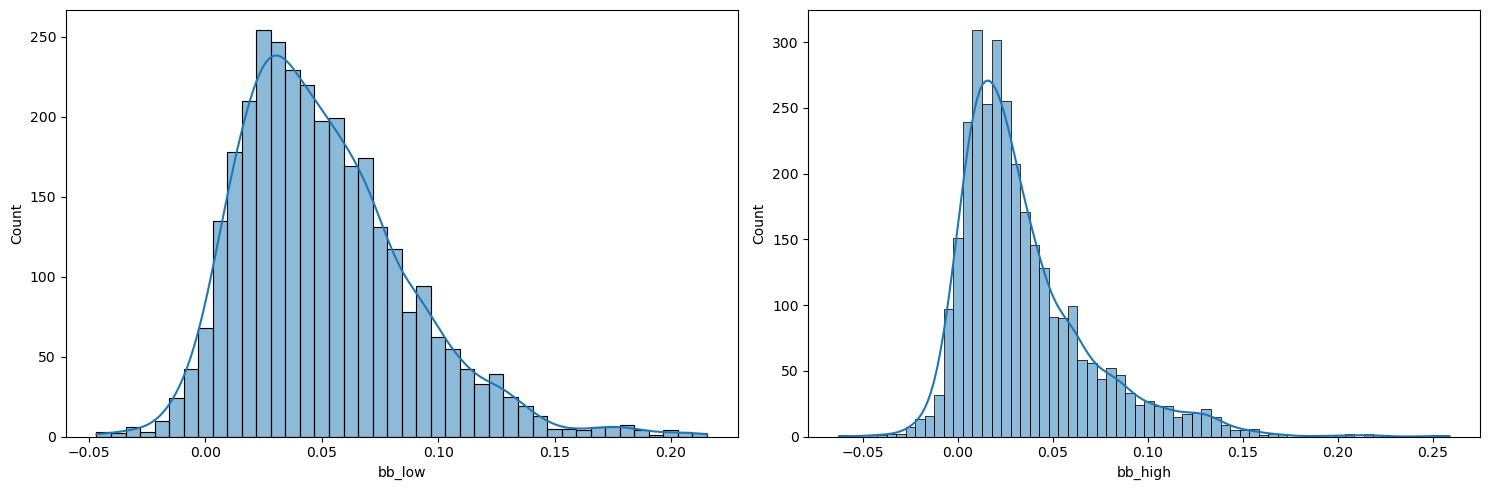

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.histplot(f.loc[:, 'bb_low'].dropna(), ax=axes[0], kde=True)
sns.histplot(f.loc[:, 'bb_high'].dropna(), ax=axes[1], kde=True)
plt.tight_layout()
save_fig("bb_bands_{}".format(ticker))

### distribution of  Average True Range

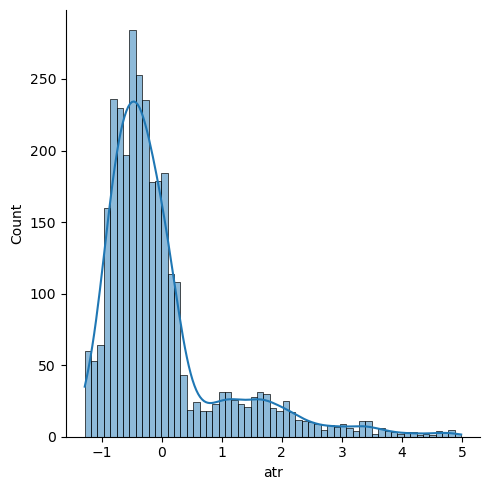

In [23]:
sns.displot(f.atr.dropna(),kde=True)
plt.tight_layout()
save_fig("atr_{}".format(ticker))

### Moving Average Convergence/Divergence

In [191]:
f.macd.describe(percentiles=[.001, .01, .02, .03, .04, .05, .95, .96, .97, .98, .99, .999]).apply(lambda x: f'{x:,.1f}')

count    3,125.0
mean         0.0
std          1.0
min         -4.6
0.1%        -4.4
1%          -3.7
2%          -2.9
3%          -2.5
4%          -2.1
5%          -1.5
50%         -0.1
95%          1.9
96%          2.1
97%          2.4
98%          2.7
99%          2.8
99.9%        4.4
max          4.6
Name: macd, dtype: object

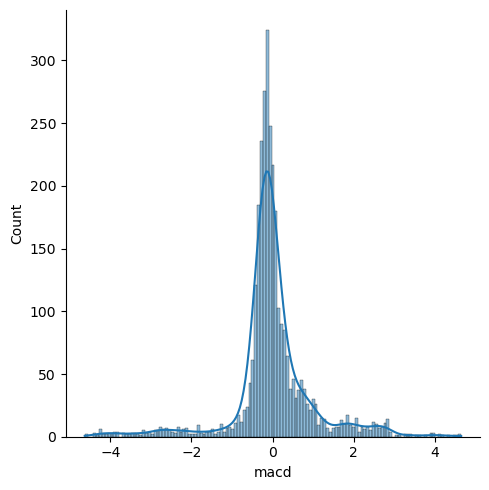

In [24]:
sns.displot(f.macd.dropna(), kde=True)
plt.tight_layout()
save_fig('macd_{}'.format(ticker))

### lagged returns

In [25]:
lags = [1, 5, 10, 21, 42, 63]

In [26]:
returns = f.close.pct_change()
percentiles=[.0001, .001, .01]
percentiles+= [1-p for p in percentiles]
returns.describe(percentiles=percentiles).iloc[2:].to_frame('percentiles').style.format(lambda x: f'{x:,.2%}')

,percentiles
std,1.64%
min,-14.74%
0.01%,-13.70%
0.1%,-9.06%
1%,-4.23%
50%,0.07%
99%,4.53%
99.9%,8.98%
99.99%,13.04%
max,14.22%


In [27]:
f.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3125 entries, 2010-07-06 to 2022-11-30
Data columns (total 52 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   open             3125 non-null   float64
 1   high             3125 non-null   float64
 2   low              3125 non-null   float64
 3   close            3125 non-null   float64
 4   volume           3125 non-null   int64  
 5   rsi              3125 non-null   float64
 6   bb_high          3125 non-null   float64
 7   bb_low           3125 non-null   float64
 8   atr              3125 non-null   float64
 9   macd             3125 non-null   float64
 10  return_1d        3125 non-null   float64
 11  return_5d        3125 non-null   float64
 12  return_10d       3125 non-null   float64
 13  return_21d       3125 non-null   float64
 14  return_42d       3125 non-null   float64
 15  return_63d       3125 non-null   float64
 16  return_1d_lag1   3125 non-null   float64
 